In [1]:
!pip install svgpath2mpl
!pip install gym

In [2]:
from collections import namedtuple
import numpy as np
import torch
import torch.nn as nn
import imageio
from svgpath2mpl import parse_path
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import rotate, shift
from matplotlib.animation import FuncAnimation
from environments.wildfire_gym import WildFireGym
from networks.lstm_ppo_net import LSTMPPONet
import torch.nn.functional as F

In [3]:

n_actions = 2
height = width = 100
channels = 2
EPISODES_PER_BATCH = 1
TRAIN_FREQ  = 10
SAVE_FREQ = 10
GAMMA = 0.95
CLIP  = 0.2
N_DRONES = 2

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMPPONet(device,  channels, height, width, n_actions).to(device)
model.load_state_dict(torch.load('ppo_weights.pt'))
model.eval()

RuntimeError: Error(s) in loading state_dict for PPONet:
	Unexpected key(s) in state_dict: "lstm.weight_ih_l0", "lstm.weight_hh_l0", "lstm.bias_ih_l0", "lstm.bias_hh_l0". 

/tmp/ipykernel_48/1193624586.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 5, figsize=(28, 4))


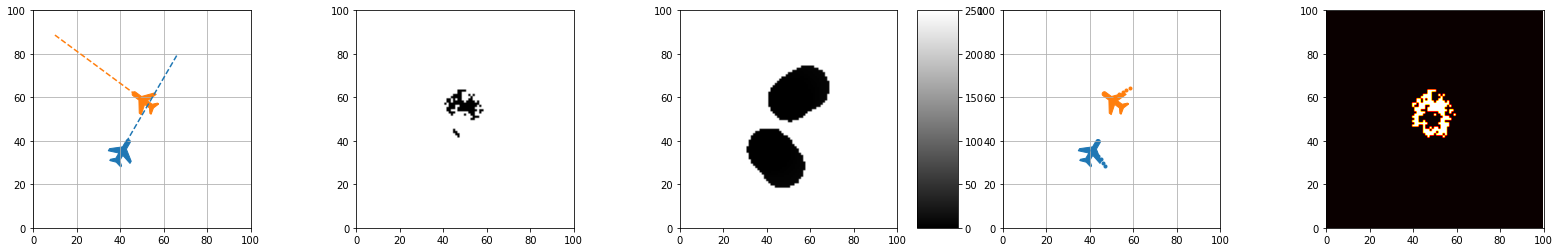

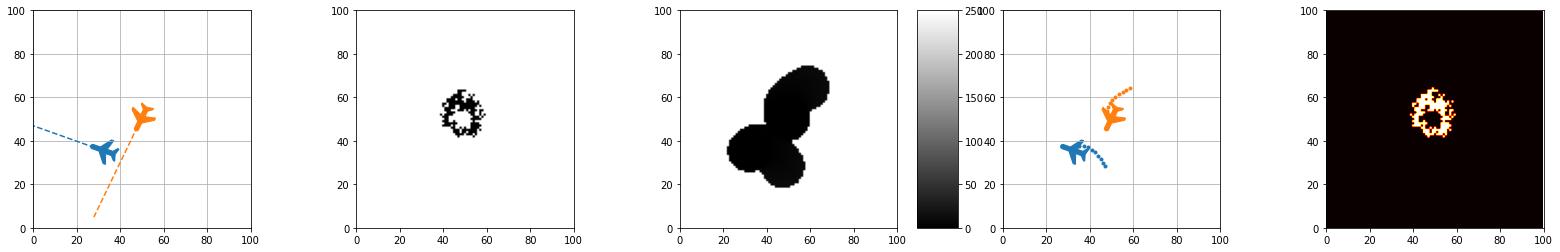

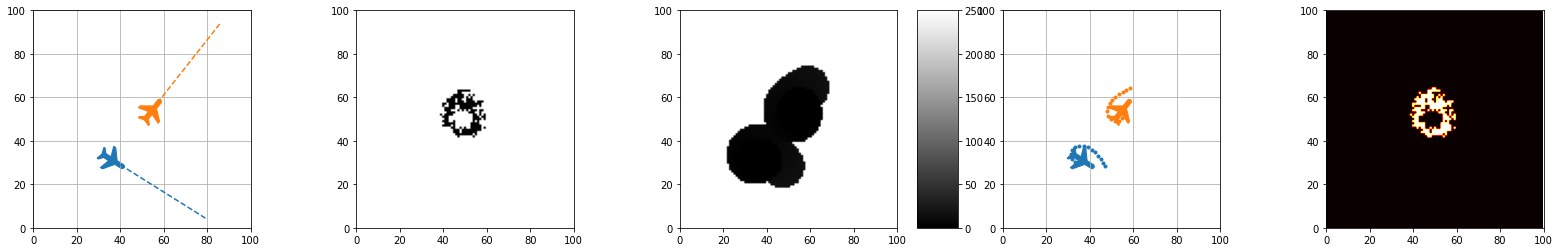

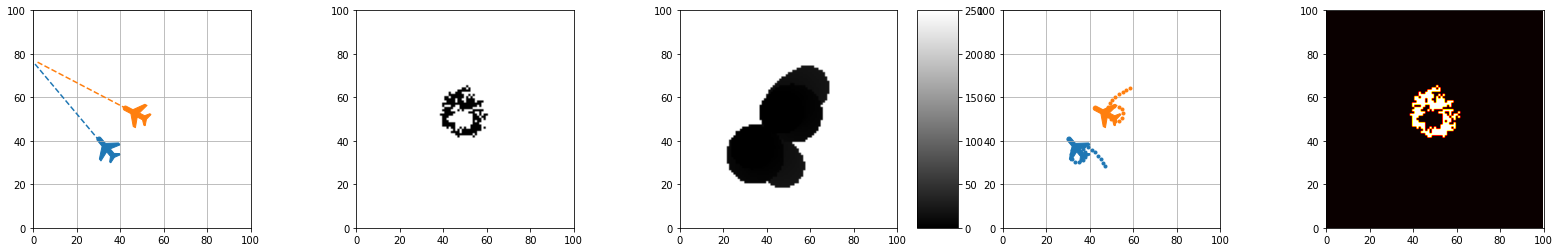

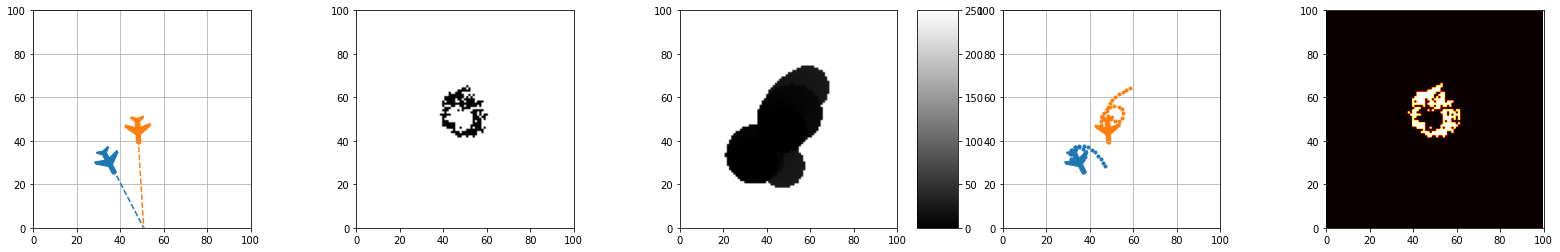

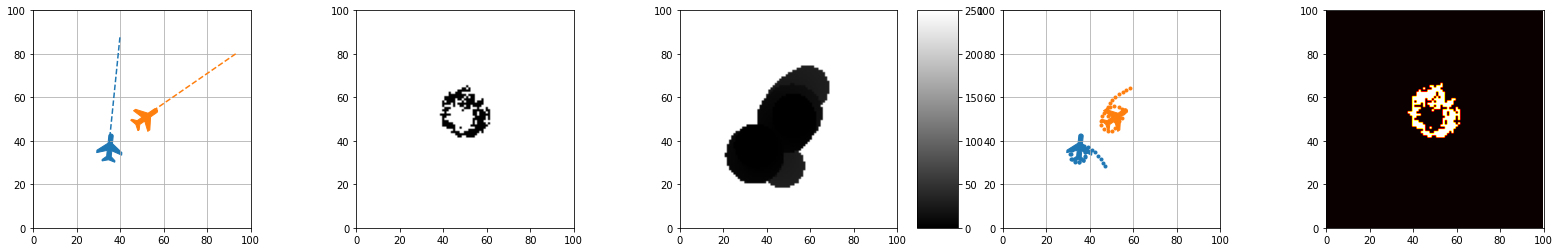

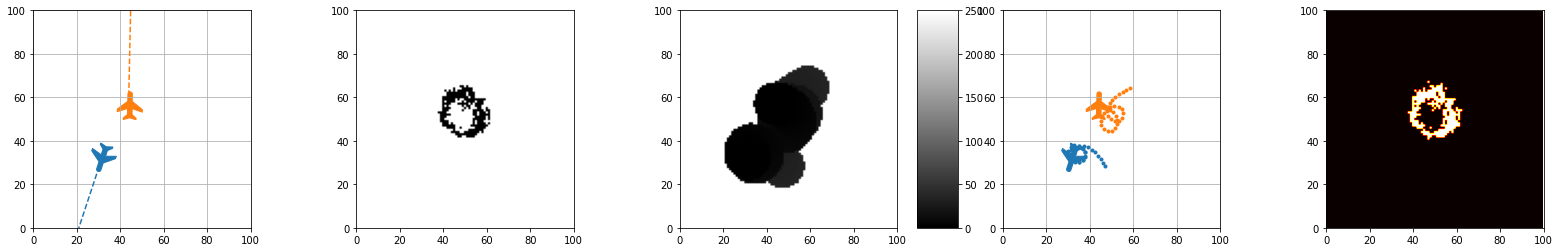

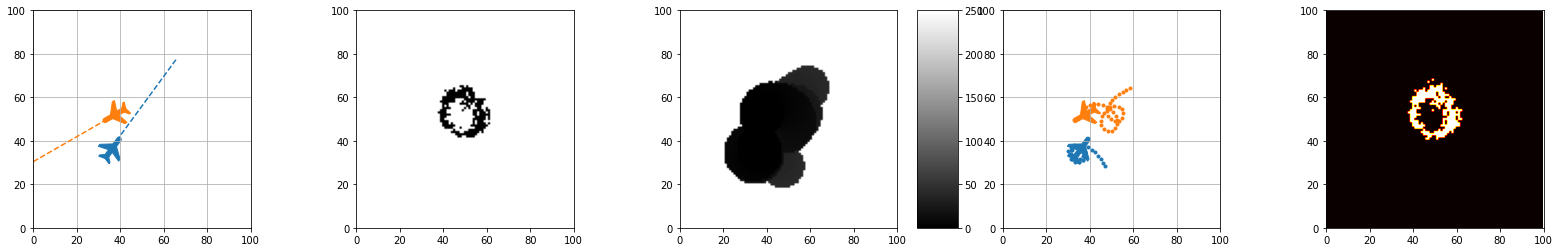

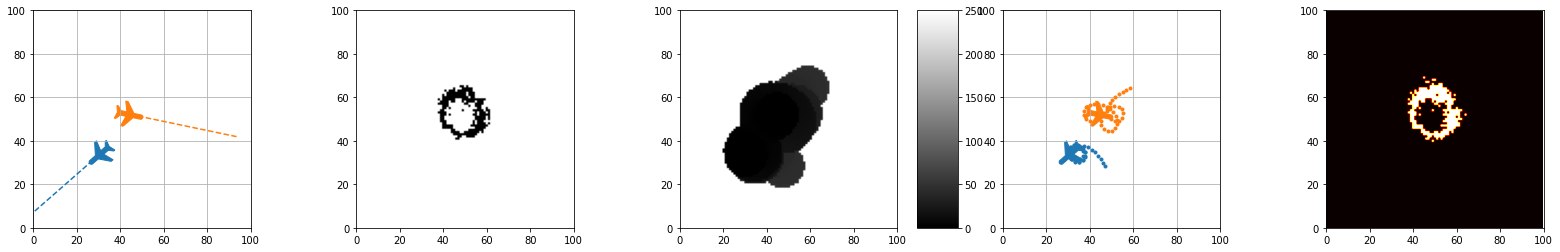

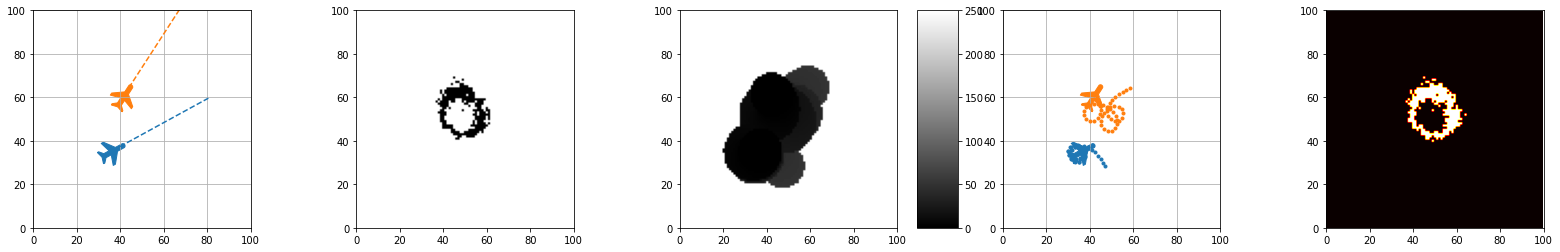

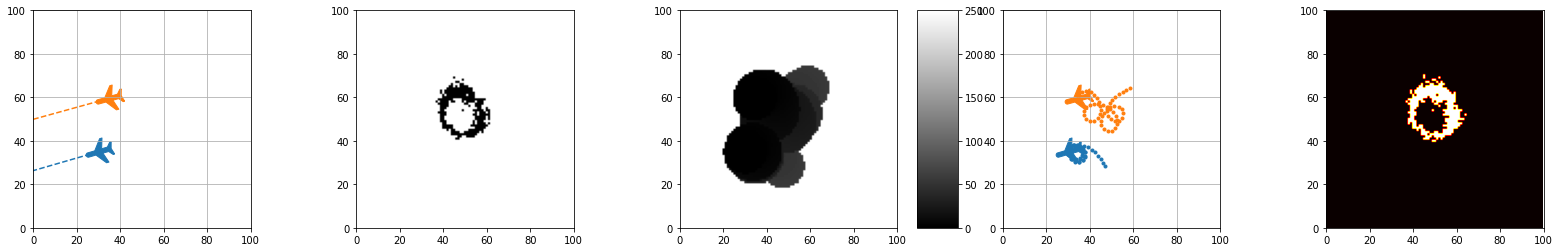

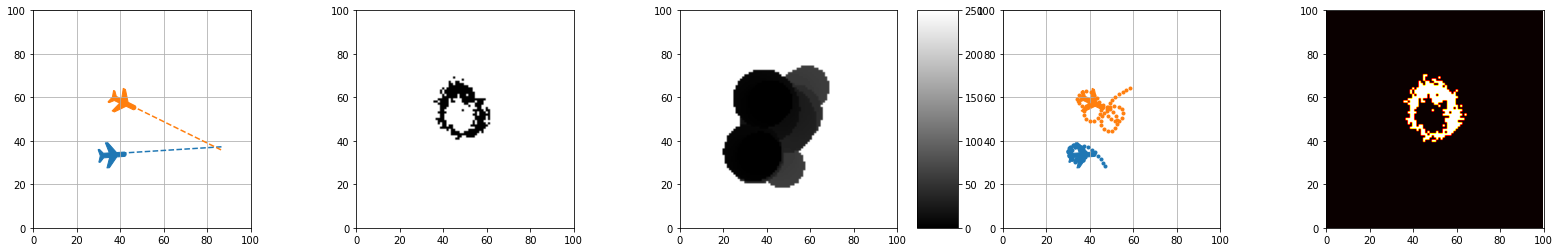

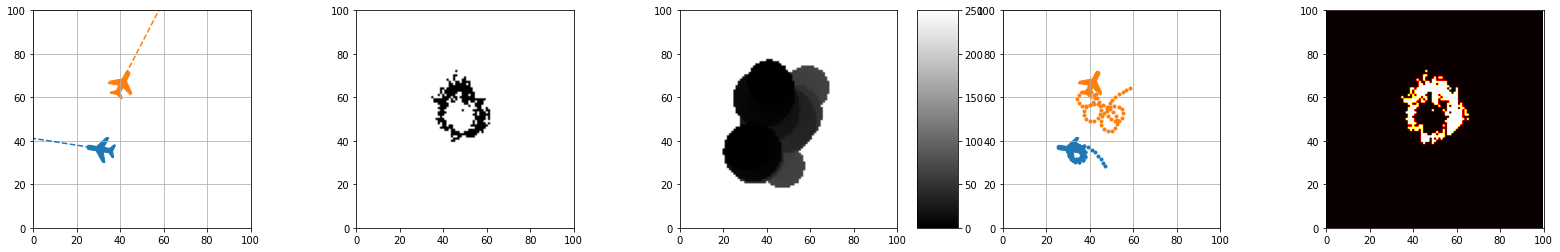

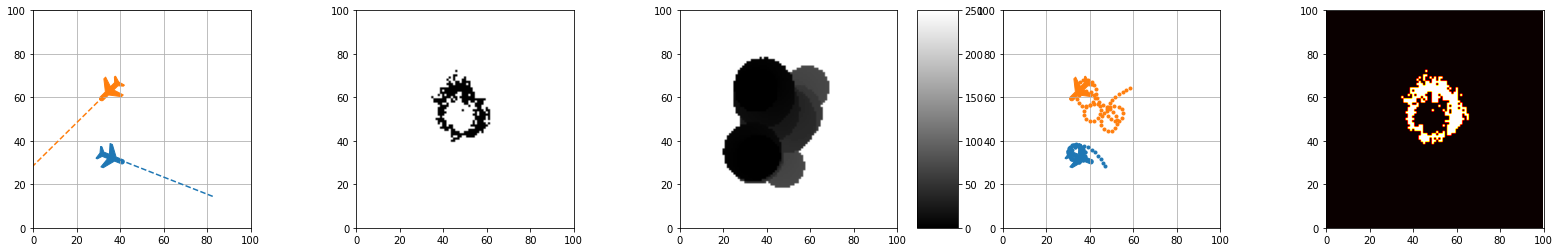

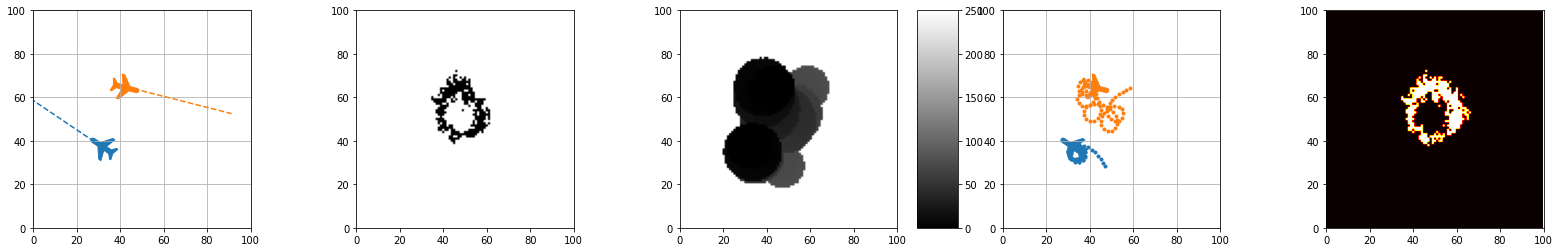

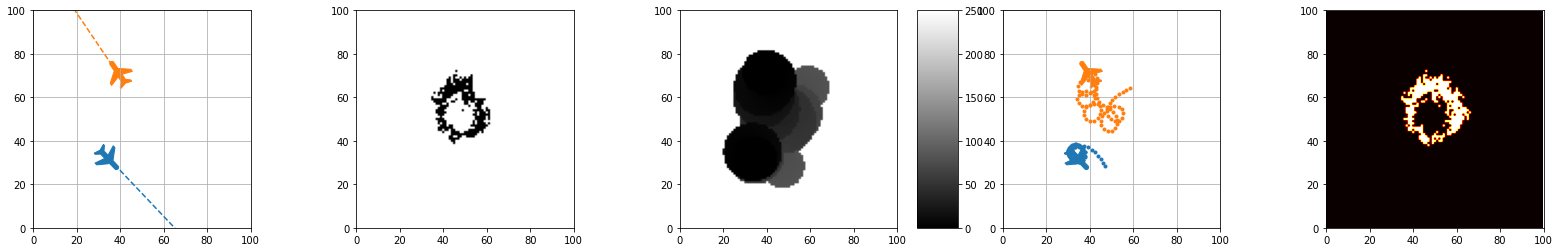

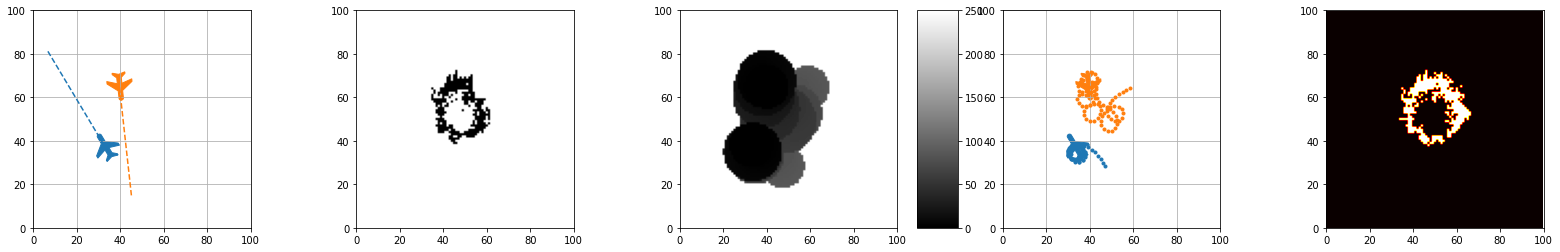

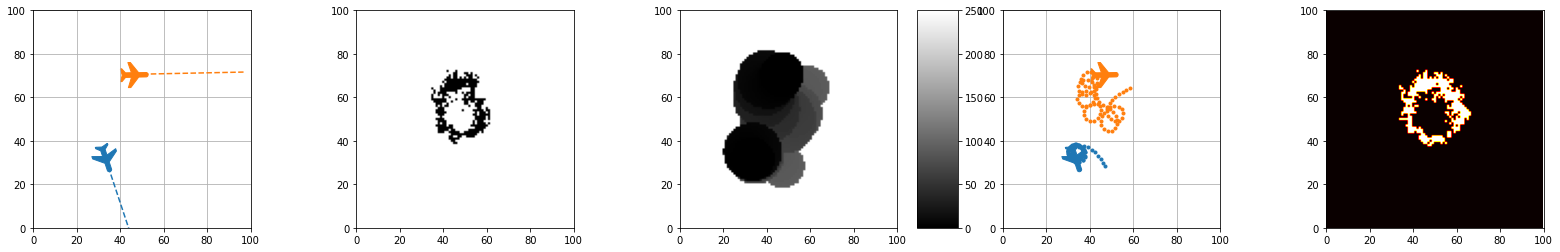

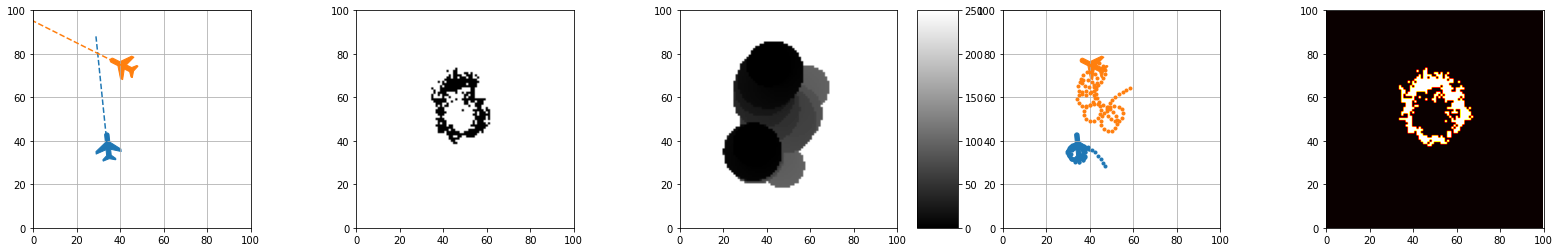

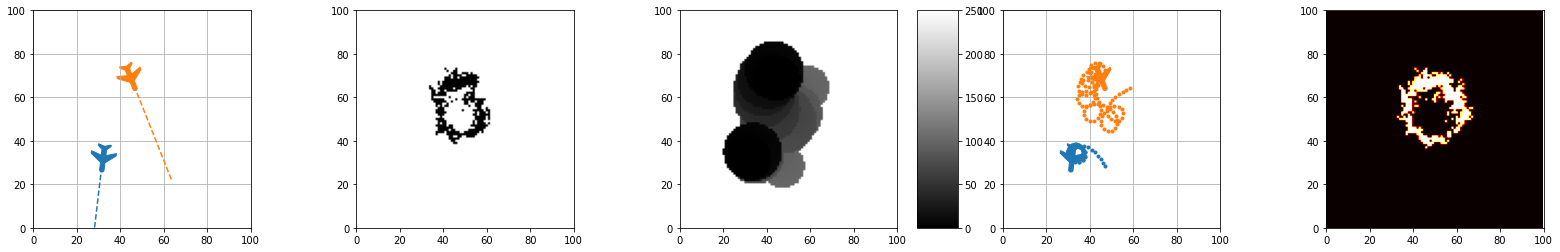

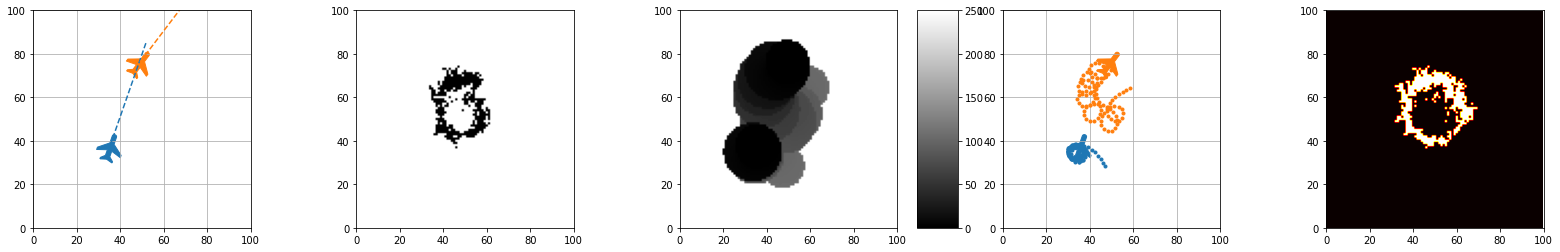

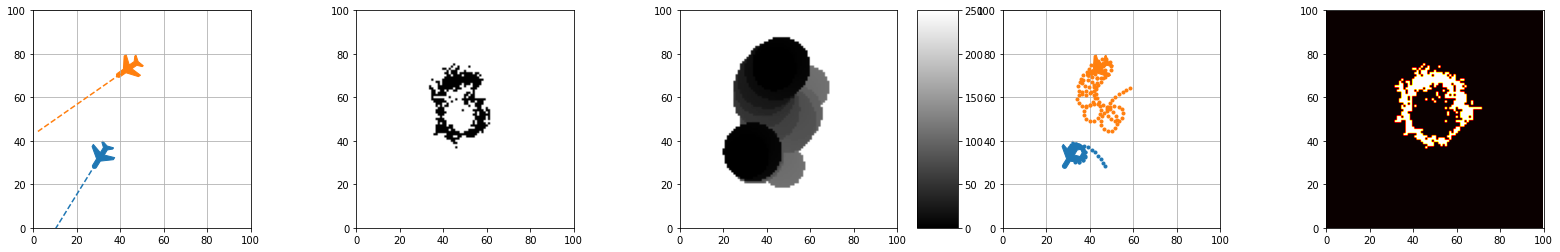

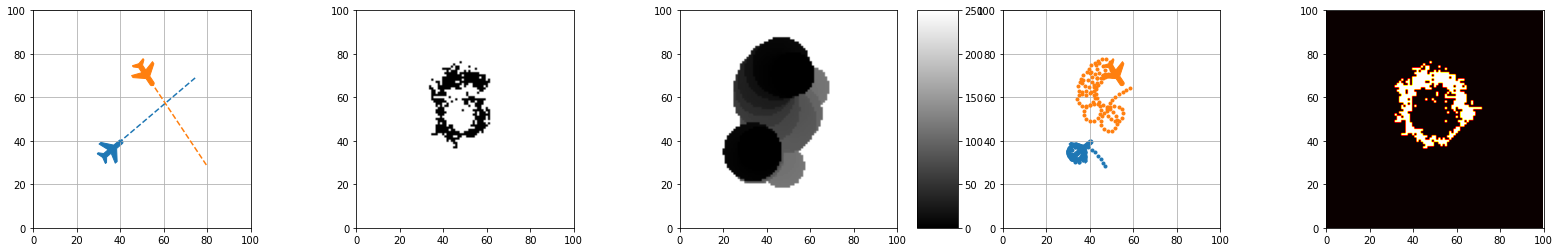

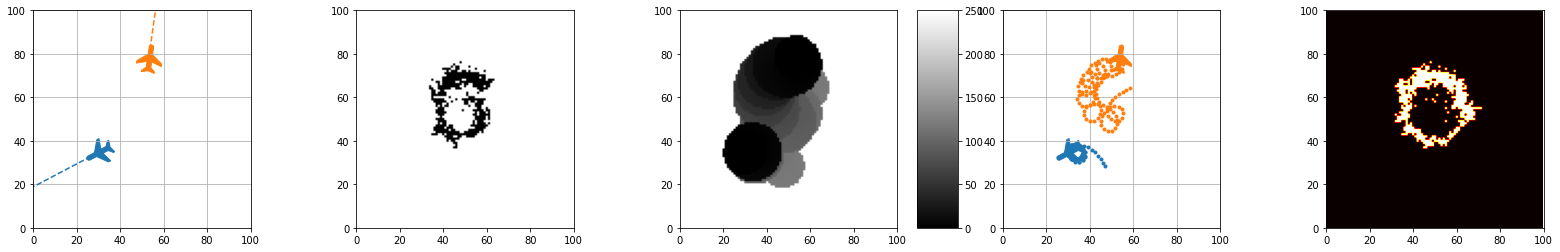

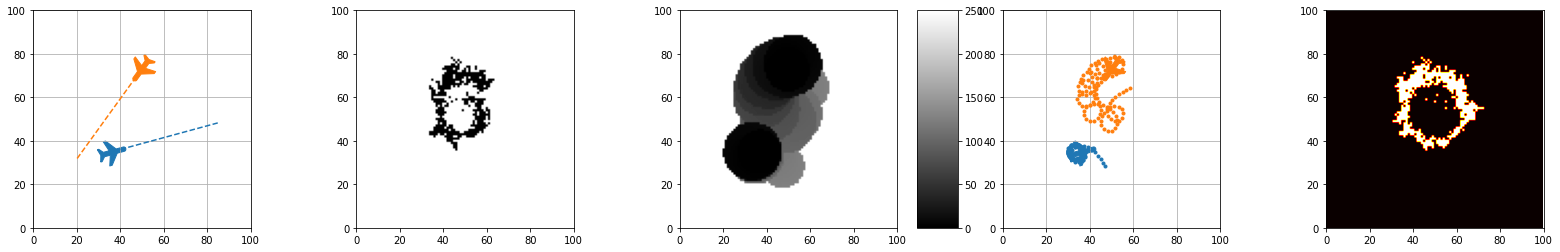

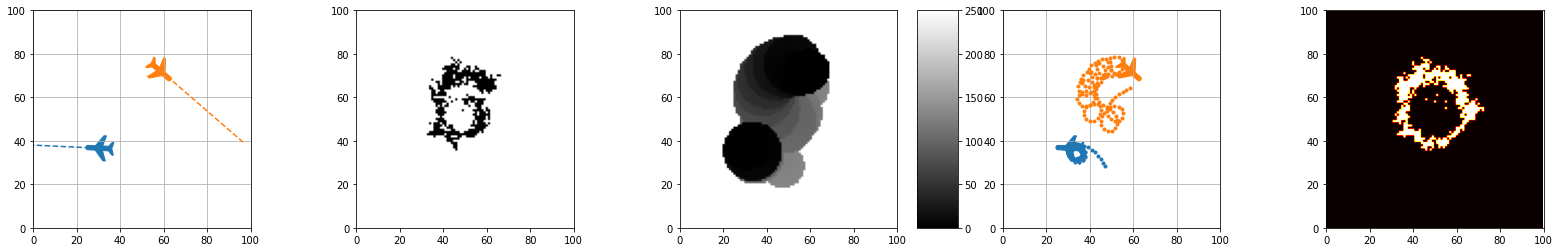

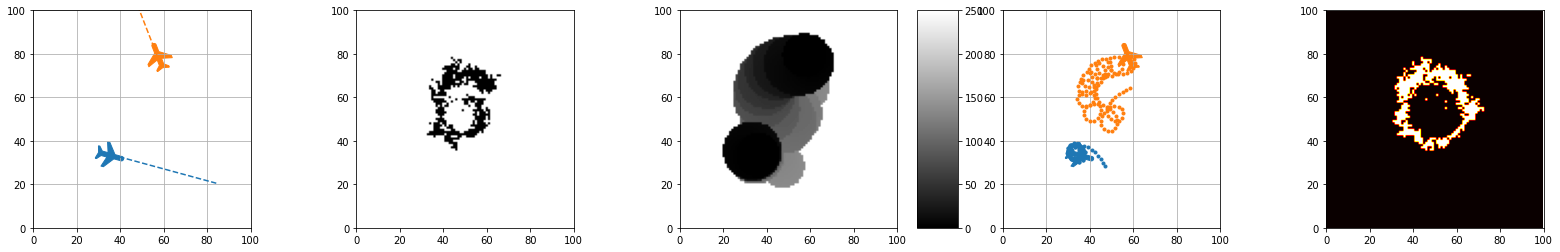

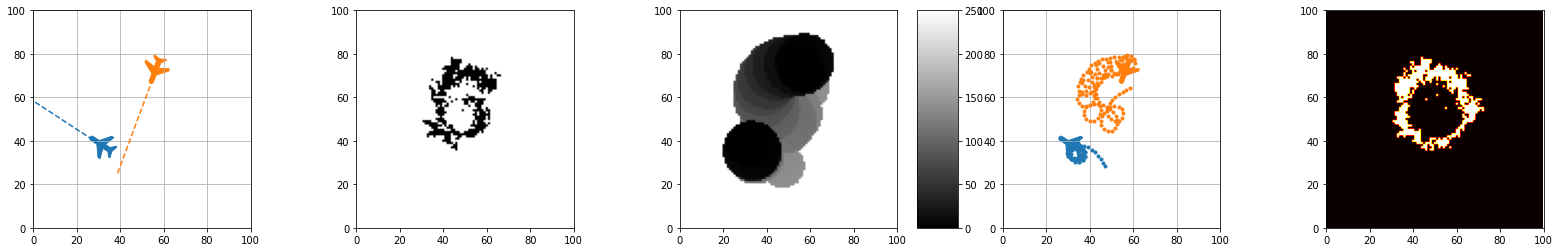

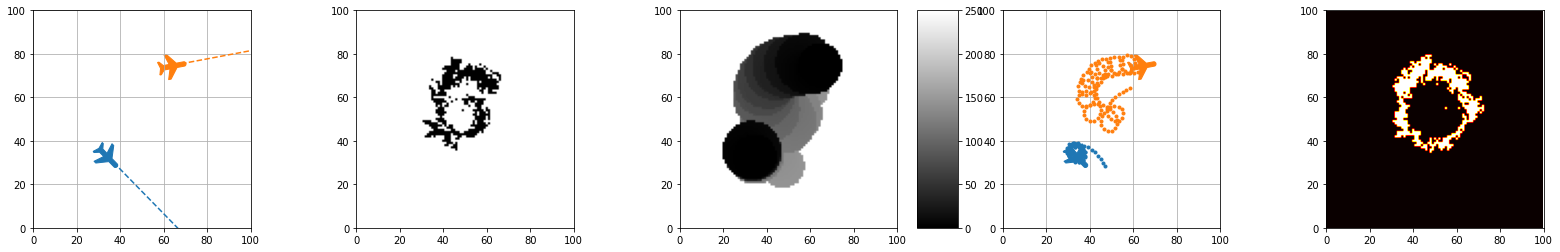

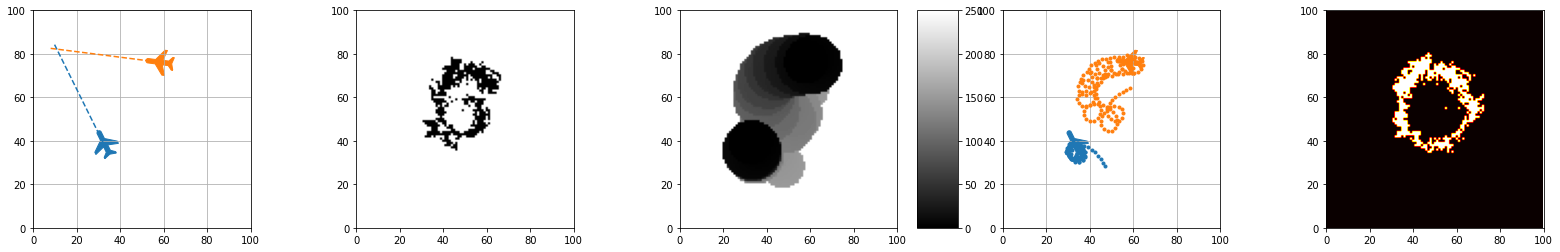

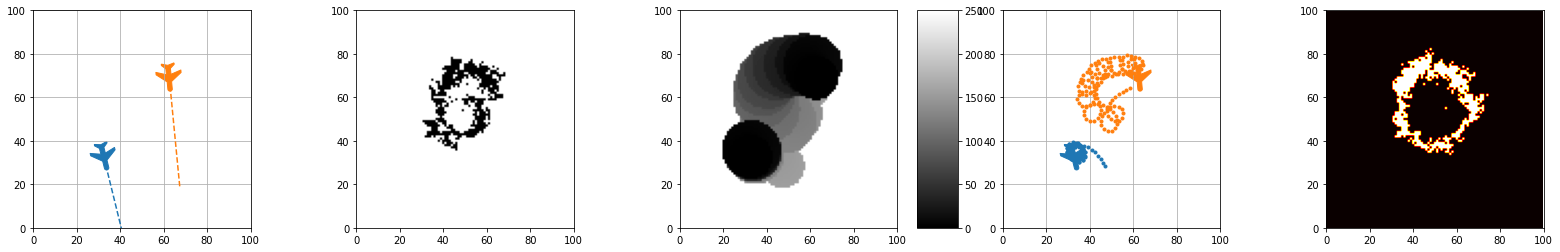

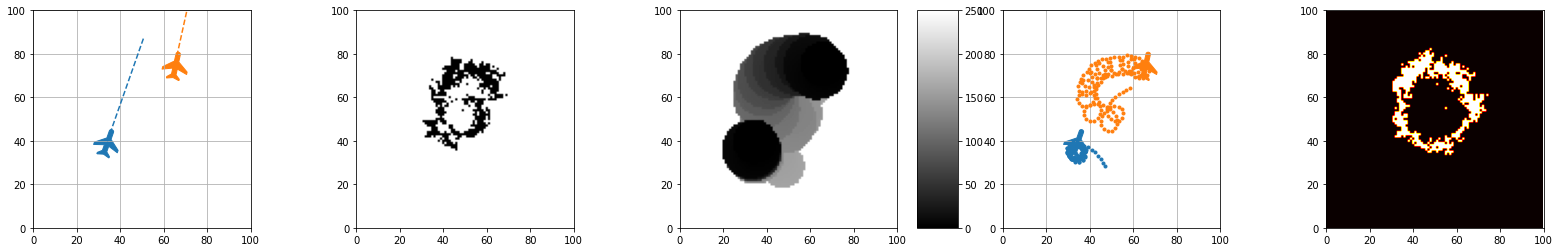

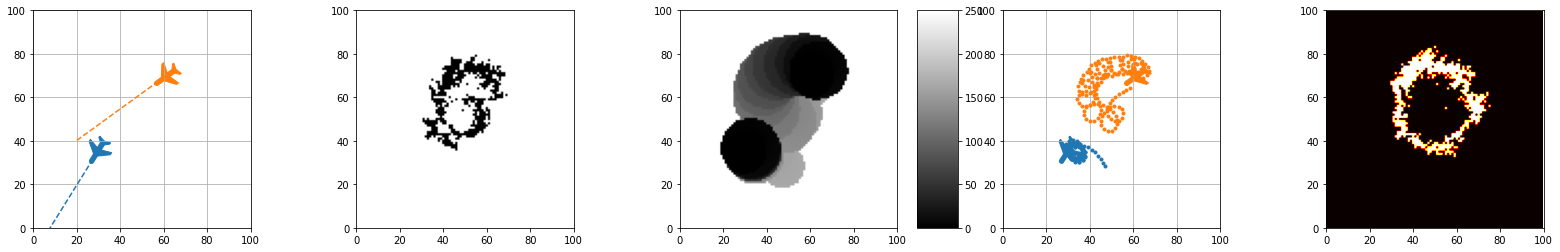

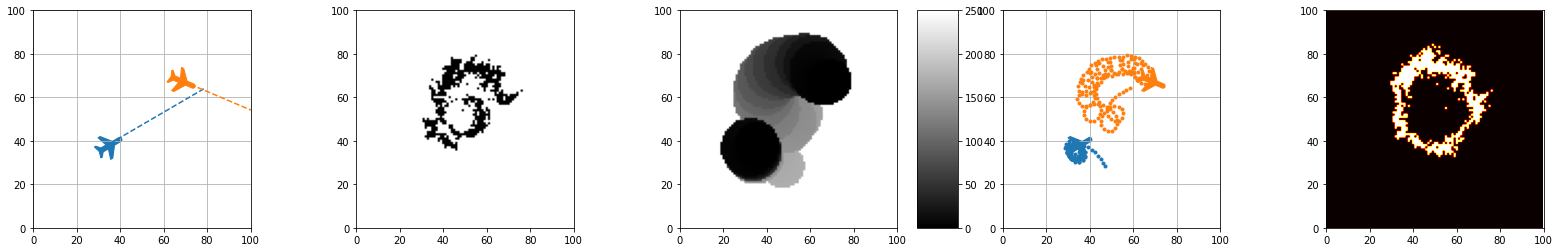

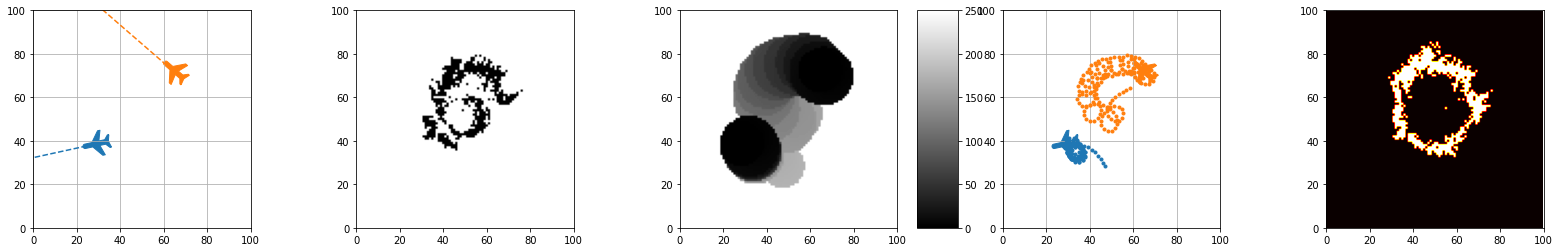

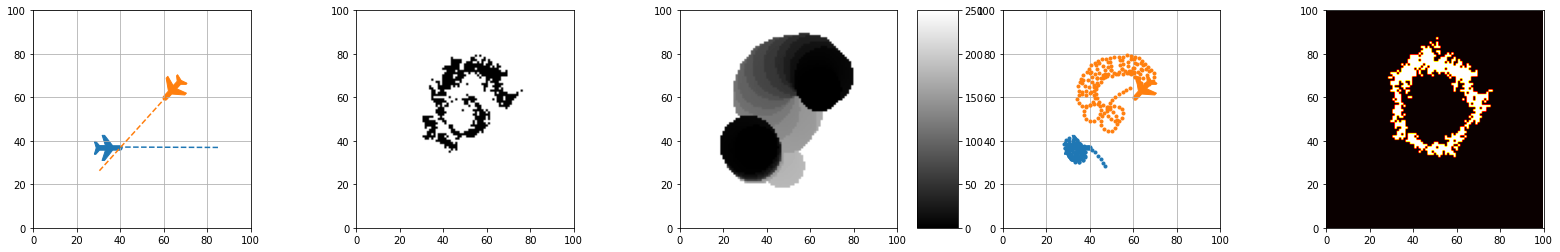

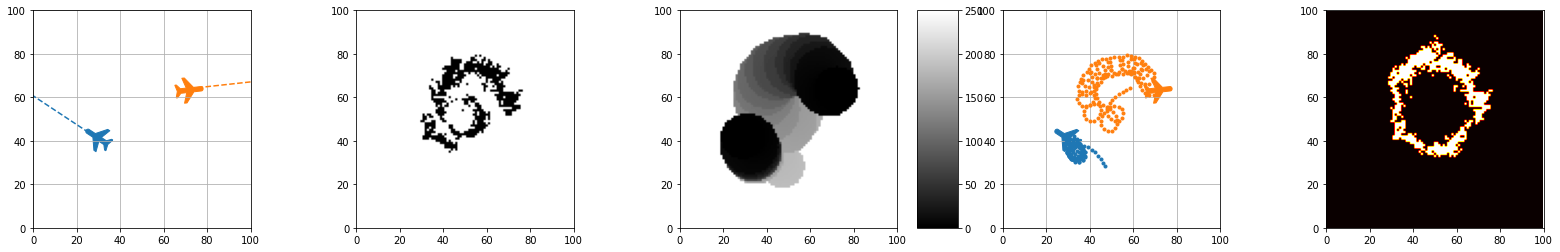

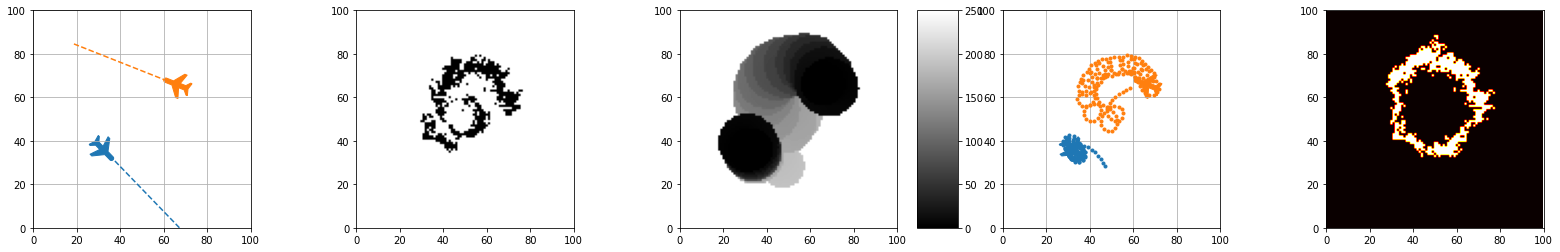

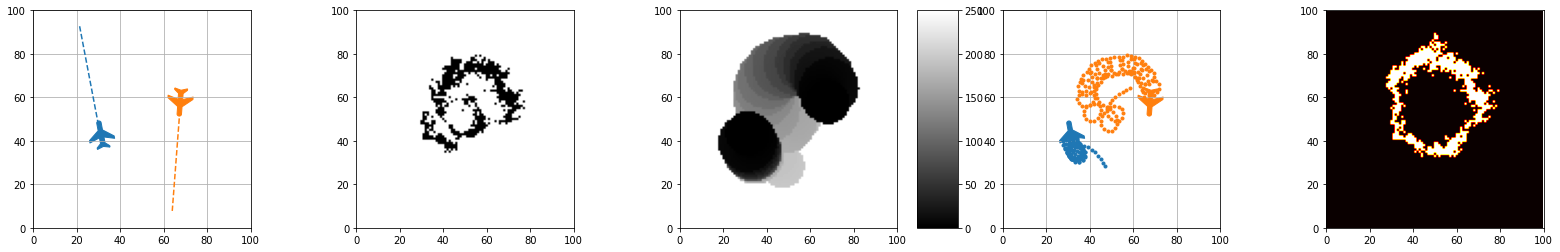

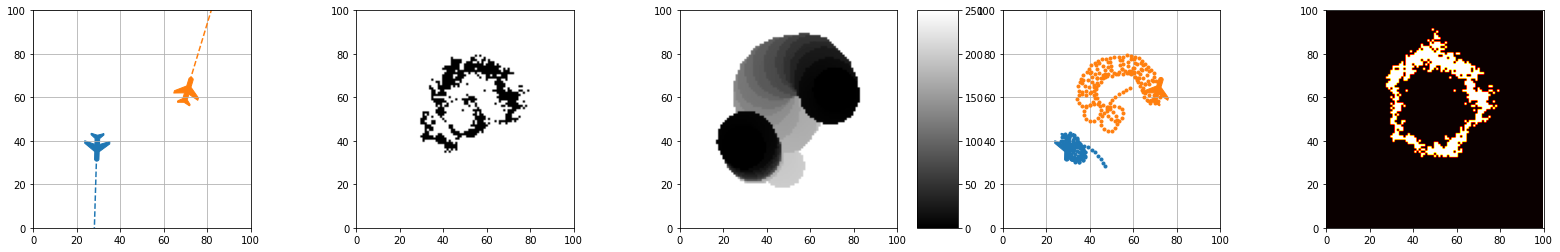

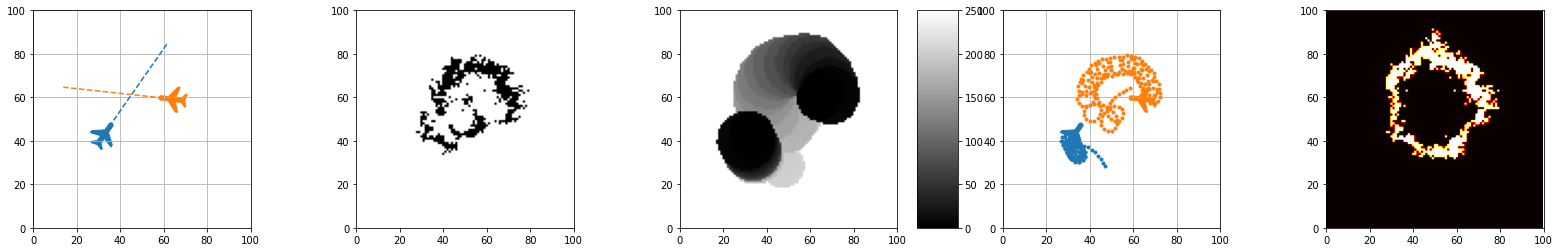

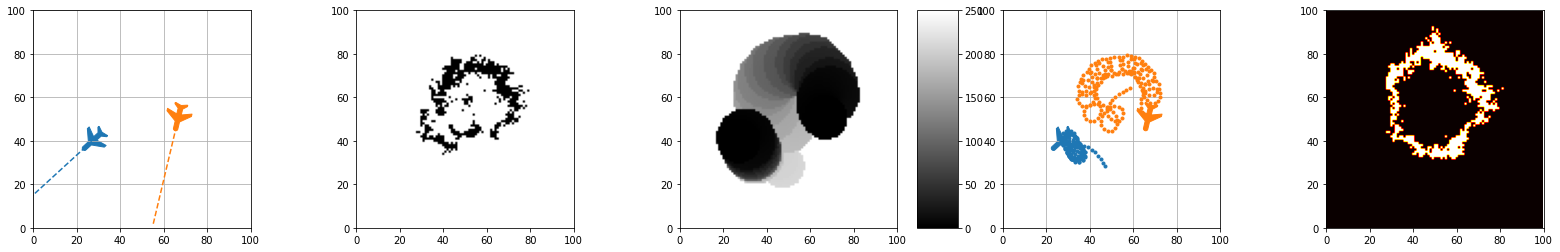

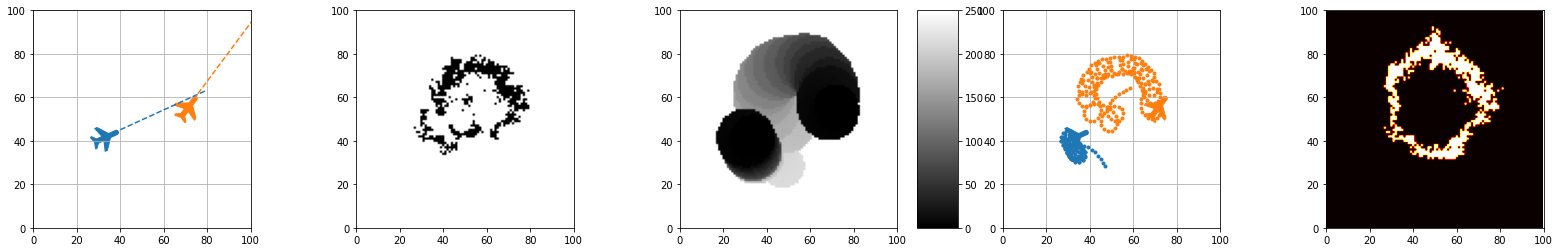

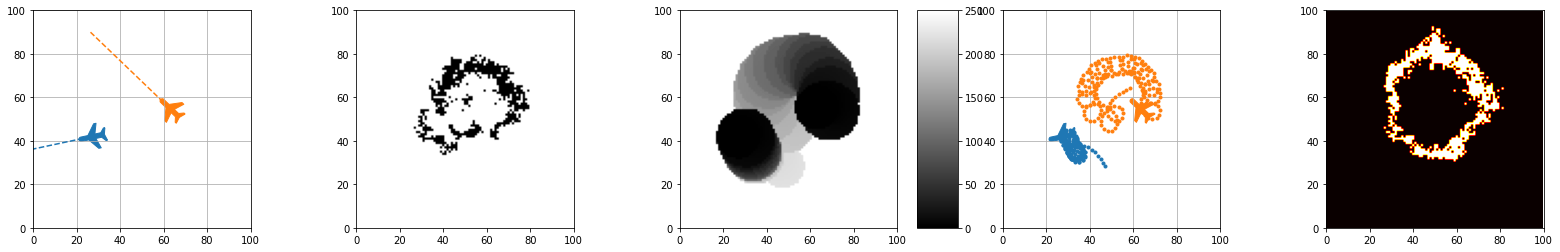

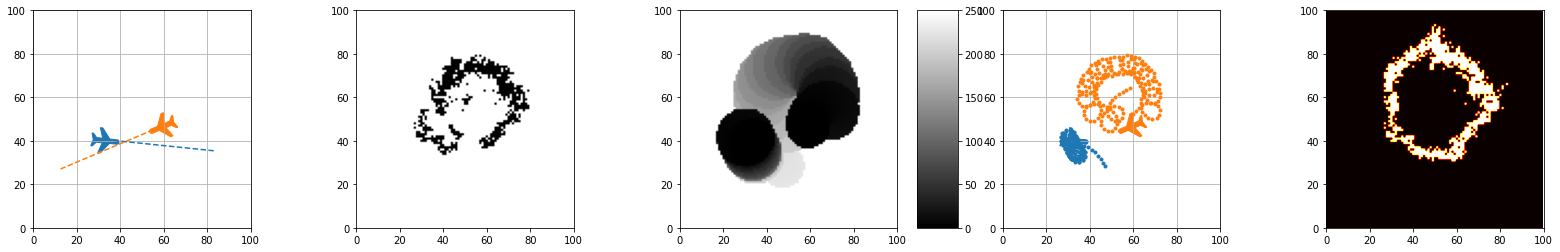

In [ ]:
loss = None
i_episode = 1
images = []
steps = 0
wildFireGym = WildFireGym()
observation = wildFireGym.reset()

maps = [None]*N_DRONES
state_vectors = [None]*N_DRONES
hidden = [None]*N_DRONES

while True:
  
  maps[0] = torch.tensor(observation[0]['belief_map'], device=device, dtype=torch.float)
  maps[1] = torch.tensor(observation[1]['belief_map'], device=device, dtype=torch.float)

  state_vectors[0] = torch.tensor(observation[0]['state_vector'], device=device, dtype=torch.float)
  state_vectors[1] = torch.tensor(observation[1]['state_vector'], device=device, dtype=torch.float)
  
  logits1, _, hidden[0] = model(maps[0], state_vectors[0], hidden[0])
  logits2, _, hidden[1] = model(maps[1], state_vectors[1], hidden[1])
  
  policy1 = F.softmax(logits1, dim=1)
  policy2 = F.softmax(logits2, dim=1)
  
  next_observation, rewards, done, _ = wildFireGym.step([ torch.argmax(policy1).item(), torch.argmax(policy2).item()])

  observation = next_observation

  if done:

    break

  observation = next_observation
  steps += 1

  if steps % 5 == 0:

    fig, ax = plt.subplots(1, 5, figsize=(28, 4))
    wildFireGym.render(fig, ax)
    fig.canvas.draw() 
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)

kwargs_write = {'fps':5.0, 'quantizer':'nq'}
imageio.mimsave('./ppo_example.gif', images, fps=5)